In [ ]:
# === Mount Google Drive and Prepare the Dataset ===
# Import the 'drive' module from Google Colab to access Google Drive
from google.colab import drive

# Mount Google Drive to the Colab environment at the specified path
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


In [ ]:
# === Install Required Libraries ===
# Install TensorFlow
!pip install tensorflow -qq

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->benign 1->malignant
    """
    if l == 1 or l == 3:
        return 0
    elif l == 2 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')


Train size: 2676 	 Test size: 336
Image size: 150x150


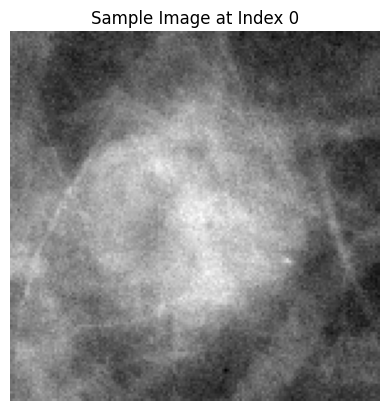

Label: 1


In [ ]:
# === Visualize a Sample Image ===
# Select an image index to visualize
idx = 0

# Display the image (grayscale, so only one channel)
plt.imshow(train_images[idx][:, :, 0], cmap='gray')
plt.title(f"Sample Image at Index {idx}")
plt.axis('off')
plt.show()

# Print the corresponding label (0 = benign, 1 = malignant)
print("Label:", train_labels[idx])


In [ ]:
# Define the CNN architecture
model_1 = models.Sequential()

# Use the Input layer directly
model_1.add(layers.Input(shape=(150, 150, 1)))

# First convolutional block
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

# Show model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,769 (19.47 MB)

 Trainable params: 5,104,769 (19.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_benmal_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model with the updated optimizer using the learning rate schedule
model_1.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history_1 = model_1.fit(
        train_generator,
        steps_per_epoch=int(0.8 * n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, lr_scheduler],  # Include earlystopping here
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save the final model after training
model_1.save('model_1_benmal_end.keras')

# Optionally copy the model to Google Drive
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5520 - loss: 0.7562
Epoch 1: val_loss improved from inf to 0.68606, saving model to model_1_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 739ms/step - accuracy: 0.5532 - loss: 0.7534 - val_accuracy: 0.5720 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6094 - loss: 0.6676

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.68606
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6094 - loss: 0.6676 - val_accuracy: 0.5720 - val_loss: 0.6988 - learning_rate: 9.9900e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6014 - loss: 0.6834
Epoch 3: val_loss improved from 0.68606 to 0.67842, saving model to model_1_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.6006 - loss: 0.6833 - val_accuracy: 0.5720 - val_loss: 0.6784 - learning_rate: 9.9800e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6094 - loss: 0.6777
Epoch 4: val_loss improved from 0.67842 to 0.67658, saving model to model_1_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6094 - loss: 0.6777 - val_accuracy: 0.5944 - val_loss: 0.6766 - learning_rate: 9.9701e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5771 - loss: 0.6841
Epoch 5: val_loss did not improve from 0.67658
16/16 ━━━━━━━━━━━━━━━━━━

In [ ]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['accuracy']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_accuracy']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1)+1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1-1]
opt_val_acc_1 = val_acc_1[opt_epoch_1-1]

# Loss and accuracy on the test set
opt_model_1 = models.load_model('model_1_benmal_best.keras')  # Load the best model
test_loss_1, test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)

# Predict using the best model
opt_pred_1 = opt_model_1.predict(test_images)  # Only pass test images
pred_classes_1 = np.rint(opt_pred_1)  # Round predictions to get class labels

# Print results
print("Model 1\n")

print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % test_acc_1)  # This should be the same as test_acc_1 for 'opt_model_1'
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % test_loss_1)

# Print classification report
print(classification_report(test_labels, pred_classes_1, digits=4))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Model 1

Epoch [end]: 500
Epoch [opt]: 498
Valid accuracy [end]: 0.6897
Valid accuracy [opt]: 0.6766
Test accuracy [end]:  0.6667
Test accuracy [opt]:  0.6667
Valid loss [end]: 0.5990
Valid loss [opt]: 0.5846
Test loss [end]:  0.6116
Test loss [opt]:  0.6116
              precision    recall  f1-score   support

           0     0.7421    0.7489    0.7455       219
           1     0.5217    0.5128    0.5172       117

    accuracy                         0.6667       336
   macro avg     0.6319    0.6308    0.6313       336
weighted avg     0.6654    0.6667    0.6660       336



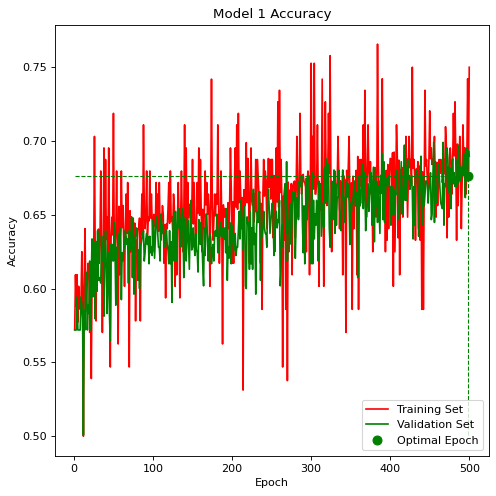

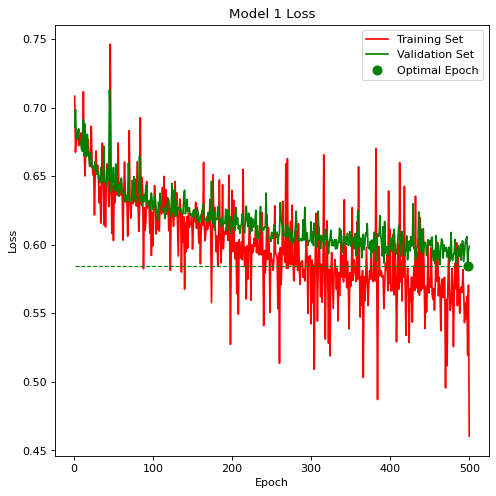

In [ ]:
# Plotting Model 1 Accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot training and validation accuracy
plt.plot(epochs_1, tra_acc_1, 'r', label='Training Set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation Set')

# Mark optimal epoch with a green dot
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go', markersize=8, label='Optimal Epoch')

# Add dashed vertical line for optimal epoch
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)

# Add dashed horizontal line for optimal validation accuracy
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)

# Add a legend
plt.legend(loc='lower right')

# Show plot
plt.show()

# Plotting Model 1 Loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training and validation loss
plt.plot(epochs_1, tra_loss_1, 'r', label='Training Set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation Set')

# Mark optimal epoch with a green dot
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go', markersize=8, label='Optimal Epoch')

# Add dashed vertical line for optimal epoch
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)

# Add dashed horizontal line for optimal validation loss
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)

# Add a legend
plt.legend()

# Show plot
plt.show()


In [ ]:
# Define Model 2 architecture
model_2 = models.Sequential([
    layers.Input(shape=(150, 150, 1)),  # Input layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Print summary
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,769 (19.47 MB)

 Trainable params: 5,104,769 (19.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_benmal_best.keras',
                             monitor='val_loss', mode='min', verbose=1,
                             save_best_only=True, save_freq='epoch')
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model with the updated optimizer using the learning rate schedule
model_2.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=int(0.8 * n_train_img) // 128,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, lr_scheduler],  # Include both callbacks
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save the final model after training
model_2.save('model_2_benmal_end.keras')

# Optionally copy the model to Google Drive (if using Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.5313 - loss: 0.7294
Epoch 1: val_loss improved from inf to 0.68693, saving model to model_2_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.5334 - loss: 0.7281 - val_accuracy: 0.5720 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5625 - loss: 0.6854

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.68693 to 0.68550, saving model to model_2_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5625 - loss: 0.6854 - val_accuracy: 0.5720 - val_loss: 0.6855 - learning_rate: 9.9900e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5893 - loss: 0.6798
Epoch 3: val_loss improved from 0.68550 to 0.68148, saving model to model_2_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.5894 - loss: 0.6798 - val_accuracy: 0.5720 - val_loss: 0.6815 - learning_rate: 9.9800e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5703 - loss: 0.6813
Epoch 4: val_loss improved from 0.68148 to 0.68024, saving model to model_2_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5703 - loss: 0.6813 - val_accuracy: 0.5720 - val_loss: 0.6802 - learning_rate: 9.9701e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5943 - loss: 0.6836
Epoch 5: val_loss improv

In [ ]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['accuracy']  # Updated key for accuracy
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_accuracy']  # Updated key for validation accuracy

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2) + 1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2 - 1]
opt_val_acc_2 = val_acc_2[opt_epoch_2 - 1]

# Loss and accuracy on the test set
opt_model_2 = models.load_model('model_2_benmal_best.keras')  # Load the best model
test_loss_2, test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)  # Evaluate the best model
opt_test_loss_2, opt_test_acc_2 = test_loss_2, test_acc_2  # Since both are from the same model

# Predict using the best model
opt_pred_2 = opt_model_2.predict(test_images)  # Only pass test images, not labels
pred_classes_2 = np.rint(opt_pred_2)  # Round predictions to get class labels

# Print results
print("Model 2\n")
print(f"Epoch [end]: {end_epoch_2}")
print(f"Epoch [opt]: {opt_epoch_2}")
print(f"Valid accuracy [end]: {end_val_acc_2:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_2:.4f}")
print(f"Test accuracy [end]: {test_acc_2:.4f}")
print(f"Test accuracy [opt]: {opt_test_acc_2:.4f}")
print(f"Valid loss [end]: {end_val_loss_2:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_2:.4f}")
print(f"Test loss [end]: {test_loss_2:.4f}")
print(f"Test loss [opt]: {opt_test_loss_2:.4f}")

# Print classification report
print(classification_report(test_labels, pred_classes_2, digits=4))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Model 2

Epoch [end]: 500
Epoch [opt]: 457
Valid accuracy [end]: 0.6841
Valid accuracy [opt]: 0.6654
Test accuracy [end]: 0.6577
Test accuracy [opt]: 0.6577
Valid loss [end]: 0.5950
Valid loss [opt]: 0.5856
Test loss [end]: 0.6250
Test loss [opt]: 0.6250
              precision    recall  f1-score   support

           0     0.7407    0.7306    0.7356       219
           1     0.5083    0.5214    0.5148       117

    accuracy                         0.6577       336
   macro avg     0.6245    0.6260    0.6252       336
weighted avg     0.6598    0.6577    0.6587       336



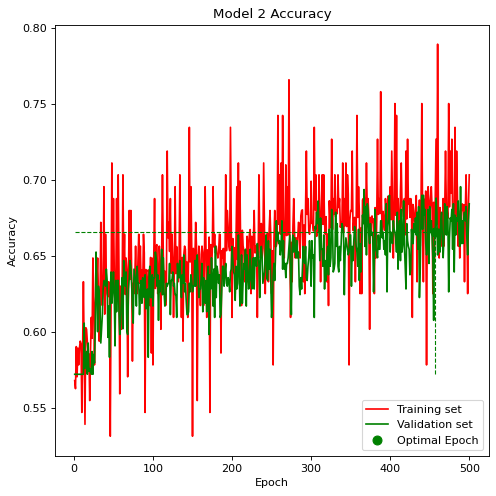

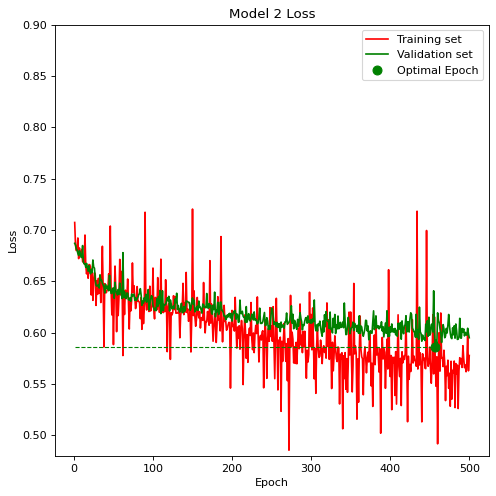

In [ ]:
# Model 2 accuracy plot
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot training and validation accuracy
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')

# Mark the optimal epoch with a green dot
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2 - 1], 'go', markersize=8, label='Optimal Epoch')

# Add dashed vertical and horizontal lines for optimal epoch
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)

# Add a legend
plt.legend(loc='lower right')

# Show plot for accuracy
plt.show()

# Model 2 loss plot
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Set y-axis limits for better visualization
plt.ylim(0.48, 0.9)

# Plot training and validation loss
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')

# Mark the optimal epoch with a green dot
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2 - 1], 'go', markersize=8, label='Optimal Epoch')

# Add dashed vertical and horizontal lines for optimal epoch
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)

# Add a legend
plt.legend()

# Show plot for loss
plt.show()


In [ ]:
model_3 = models.Sequential()

# Use the Input layer to define input shape
model_3.add(layers.Input(shape=(150, 150, 1)))  # Define input shape as 150x150x1

# Then, proceed with your convolutional and pooling layers
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,104,769 (19.47 MB)

 Trainable params: 5,104,769 (19.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_benmal_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)
# Compile the model with updated learning rate schedule
model_3.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train using the `fit` method instead of the deprecated `fit_generator`
history_3 = model_3.fit(
        train_generator,
        steps_per_epoch=int(0.8 * n_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, lr_scheduler],  # Adding early stopping here
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save the final model after training
model_3.save('model_3_benmal_end.keras')

# Optionally copy the model to Google Drive (if using Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5272 - loss: 0.9726
Epoch 1: val_loss improved from inf to 0.68912, saving model to model_3_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.5290 - loss: 0.9631 - val_accuracy: 0.5720 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5234 - loss: 0.7037

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.68912 to 0.68824, saving model to model_3_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5234 - loss: 0.7037 - val_accuracy: 0.5720 - val_loss: 0.6882 - learning_rate: 9.9900e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5846 - loss: 0.6850
Epoch 3: val_loss improved from 0.68824 to 0.68677, saving model to model_3_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.5843 - loss: 0.6849 - val_accuracy: 0.5720 - val_loss: 0.6868 - learning_rate: 9.9800e-04
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5484 - loss: 0.6943
Epoch 4: val_loss improved from 0.68677 to 0.68247, saving model to model_3_benmal_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5484 - loss: 0.6943 - val_accuracy: 0.5720 - val_loss: 0.6825 - learning_rate: 9.9701e-04
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5740 - loss: 0.6821
Epoch 5: val_loss did no

In [ ]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['accuracy']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_accuracy']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3) + 1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3 - 1]
opt_val_acc_3 = val_acc_3[opt_epoch_3 - 1]

# Load the best model
opt_model_3 = models.load_model('model_3_benmal_best.keras')

# Loss and accuracy on the test set
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)

# Get predictions (Only pass test_images, not test_labels)
opt_pred_3 = opt_model_3.predict(test_images)
pred_classes_3 = np.rint(opt_pred_3)  # Round predictions to get binary labels (0 or 1)

# Print results
print("Model 3\n")
print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

# Classification report
print(classification_report(test_labels, pred_classes_3, digits=4))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Model 3

Epoch [end]: 500
Epoch [opt]: 491
Valid accuracy [end]: 0.6636
Valid accuracy [opt]: 0.6804
Test accuracy [end]:  0.6935
Test accuracy [opt]:  0.6786
Valid loss [end]: 0.6032
Valid loss [opt]: 0.5736
Test loss [end]:  0.5779
Test loss [opt]:  0.6037
              precision    recall  f1-score   support

           0     0.7424    0.7763    0.7589       219
           1     0.5421    0.4957    0.5179       117

    accuracy                         0.6786       336
   macro avg     0.6422    0.6360    0.6384       336
weighted avg     0.6726    0.6786    0.6750       336



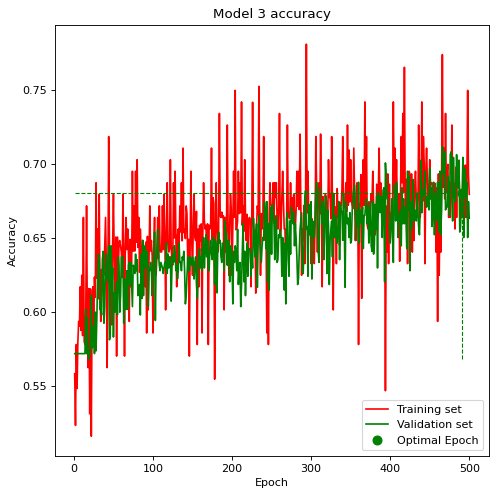

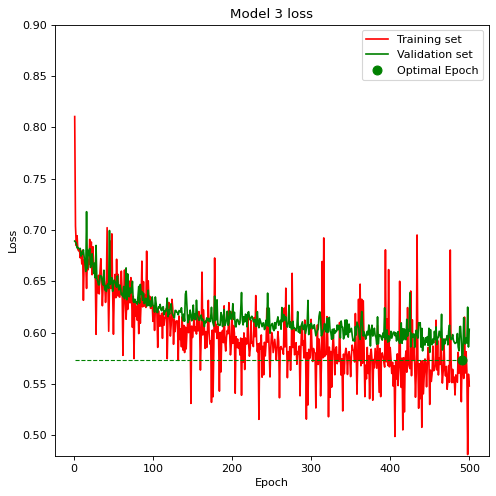

In [ ]:
# Model accuracy plot
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go',  markersize=8, label='Optimal Epoch')  # Highlight optimal epoch
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')
plt.show()

# Model loss plot
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.48, 0.9)  # Adjust the y-axis limits for clarity
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go', markersize=8, label='Optimal Epoch')  # Highlight optimal epoch
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend()

plt.show()